# Advanced Modeling with Historical Data

This notebook:
1. Fetches **multiple years** of team data from Barttorvik (2019-2025)
2. Builds training data from historical team efficiency ratings
3. Trains ML models with proper cross-validation
4. Evaluates with MAE/RMSE metrics
5. Generates prediction intervals for 2026 games

In [1]:
import pandas as pd
import numpy as np
import requests
import ssl
import urllib.request
from io import StringIO
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ML imports
from sklearn.linear_model import LinearRegression, Ridge, QuantileRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Fetch Historical Team Data from Barttorvik (Multiple Years)

We'll fetch team efficiency ratings from multiple seasons using `https://barttorvik.com/{year}_team_results.csv`

In [2]:
def fetch_barttorvik_year(year):
    """
    Fetch team results from Barttorvik for a given year.
    URL format: https://barttorvik.com/{year}_team_results.csv
    """
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE
    
    url = f"https://barttorvik.com/{year}_team_results.csv"
    
    try:
        req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
        with urllib.request.urlopen(req, context=ssl_context, timeout=30) as response:
            content = response.read().decode('utf-8')
        
        # Check if we got HTML instead of CSV
        if content.strip().startswith('<!DOCTYPE') or content.strip().startswith('<html'):
            print(f"  {year}: Browser auth required")
            return None
        
        df = pd.read_csv(StringIO(content))
        df['season'] = year
        print(f"  {year}: ✓ {len(df)} teams")
        return df
    except Exception as e:
        print(f"  {year}: Error - {e}")
        return None

# Fetch multiple years of historical data
print("Fetching historical data from Barttorvik...")
print("=" * 40)

years_to_fetch = [2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026]
all_years_data = []

for year in years_to_fetch:
    df = fetch_barttorvik_year(year)
    if df is not None:
        all_years_data.append(df)

if all_years_data:
    historical_data = pd.concat(all_years_data, ignore_index=True)
    print(f"\n✓ Total: {len(historical_data)} team-seasons loaded")
    print(f"  Seasons: {historical_data['season'].unique().tolist()}")
else:
    print("\n⚠️ No data fetched - check connection")
    historical_data = None

Fetching historical data from Barttorvik...
  2019: ✓ 353 teams
  2020: ✓ 353 teams
  2021: ✓ 347 teams
  2022: ✓ 358 teams
  2023: ✓ 363 teams
  2024: ✓ 362 teams
  2025: ✓ 364 teams
  2026: ✓ 365 teams

✓ Total: 2865 team-seasons loaded
  Seasons: [2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026]


In [3]:
# Inspect the data structure
if historical_data is not None:
    print("Columns available:")
    print(historical_data.columns.tolist())
    print(f"\nSample from 2025 season:")
    display(historical_data[historical_data['season'] == 2025].head(10))

Columns available:
['rank', 'team', 'conf', 'record', 'adjoe', 'oe Rank', 'adjde', 'de Rank', 'barthag', 'rank.1', 'proj. W', 'Proj. L', 'Pro Con W', 'Pro Con L', 'Con Rec.', 'sos', 'ncsos', 'consos', 'Proj. SOS', 'Proj. Noncon SOS', 'Proj. Con SOS', 'elite SOS', 'elite noncon SOS', 'Opp OE', 'Opp DE', 'Opp Proj. OE', 'Opp Proj DE', 'Con Adj OE', 'Con Adj DE', 'Qual O', 'Qual D', 'Qual Barthag', 'Qual Games', 'FUN', 'ConPF', 'ConPA', 'ConPoss', 'ConOE', 'ConDE', 'ConSOSRemain', 'Conf Win%', 'WAB', 'WAB Rk', 'Fun Rk, adjt', 'season', 'Fun Rk', 'adjt']

Sample from 2025 season:


,rank,team,conf,record,adjoe,oe Rank,adjde,de Rank,barthag,rank.1,...,ConOE,ConDE,ConSOSRemain,Conf Win%,WAB,WAB Rk,"Fun Rk, adjt",season,Fun Rk,adjt
2136,1,Houston,B12,35-5,124.692322,11.0,87.347535,1.0,0.983593,1,...,1.152263,0.954093,0.0,0.950000,11.536627,2,NaN,2025,146.0,61.781372
2137,2,Duke,ACC,35-4,130.567943,1.0,92.014057,4.0,0.982441,2,...,1.282943,0.953087,0.0,0.950000,9.474208,5,NaN,2025,166.0,65.963349
2138,3,Auburn,SEC,32-6,127.682527,4.0,92.973664,9.0,0.974622,3,...,1.181923,1.051214,0.0,0.833333,12.703623,1,NaN,2025,48.0,68.286561
2139,4,Florida,SEC,36-4,127.786000,2.0,94.180332,13.0,0.970948,4,...,1.183017,1.028259,0.0,0.777778,11.145702,3,NaN,2025,14.0,69.903866
2140,5,Alabama,SEC,28-9,127.738128,3.0,96.622934,26.0,0.961224,5,...,1.196519,1.089649,0.0,0.722222,10.117114,4,NaN,2025,58.0,75.063576
2141,6,Tennessee,SEC,30-8,120.158028,18.0,91.877556,3.0,0.956313,6,...,1.087666,1.018295,0.0,0.666667,9.327841,6,NaN,2025,38.0,63.920988
2142,7,Texas Tech,B12,28-9,126.063221,6.0,97.576879,37.0,0.950057,7,...,1.164705,1.022559,0.0,0.750000,5.835554,11,NaN,2025,175.0,66.138413
2143,8,Gonzaga,WCC,26-9,124.801065,10.0,96.708505,28.0,0.949441,8,...,1.244509,1.000796,0.0,0.777778,2.814735,32,NaN,2025,332.0,70.507217
2144,9,Maryland,B10,27-9,118.622271,24.0,92.091820,5.0,0.948403,9,...,1.098612,0.998931,0.0,0.700000,5.161789,18,NaN,2025,237.0,69.705411
2145,10,Arizona,B12,24-13,124.917732,9.0,97.405721,34.0,0.945877,10,...,1.142582,1.064029,0.0,0.700000,5.446122,16,NaN,2025,233.0,70.274841


## 2. Process Historical Data for Training

We'll extract efficiency ratings and create training matchups from historical seasons.

In [4]:
# Find the relevant columns in Barttorvik data
def find_col(df, keywords):
    """Find column matching any keyword"""
    for kw in keywords:
        for col in df.columns:
            if kw.lower() in col.lower():
                return col
    return None

# Identify key columns
if historical_data is not None:
    team_col = find_col(historical_data, ['team'])
    adj_o_col = find_col(historical_data, ['adjoe', 'adj_o'])
    adj_d_col = find_col(historical_data, ['adjde', 'adj_d'])
    
    print(f"Team column: {team_col}")
    print(f"Adj Offense column: {adj_o_col}")
    print(f"Adj Defense column: {adj_d_col}")
    
    # Create standardized historical dataset
    hist_df = historical_data[[team_col, adj_o_col, adj_d_col, 'season']].copy()
    hist_df.columns = ['team', 'adj_oe', 'adj_de', 'season']
    hist_df['net_eff'] = hist_df['adj_oe'] - hist_df['adj_de']
    
    print(f"\nProcessed {len(hist_df)} team-seasons")
    display(hist_df.sort_values(['season', 'net_eff'], ascending=[False, False]).head(20))

Team column: team
Adj Offense column: adjoe
Adj Defense column: adjde

Processed 2865 team-seasons


,team,adj_oe,adj_de,season,net_eff
2500,Michigan,128.037433,89.519938,2026,38.517496
2501,Arizona,125.434628,92.591606,2026,32.843022
2505,Purdue,130.442165,98.102070,2026,32.340095
2504,Illinois,129.833755,97.595486,2026,32.238269
2502,Connecticut,122.886843,91.476202,2026,31.410641
2506,Vanderbilt,126.202268,95.030106,2026,31.172163
2503,Houston,122.525435,91.483989,2026,31.041446
2513,Alabama,133.004255,103.986864,2026,29.017391
2509,Virginia,125.419047,96.649135,2026,28.769912
2508,Gonzaga,124.558543,95.959689,2026,28.598854


In [5]:
# Load our 2026 team stats and prediction template
team_stats_2026 = pd.read_csv('../data/processed/team_stats_2025_26.csv')
template = pd.read_csv('../tsa_pt_spread_template_2026 - Sheet1.csv')

print(f"2026 team stats: {len(team_stats_2026)} teams")
print(f"Games to predict: {len(template)}")
display(team_stats_2026.head())

2026 team stats: 21 teams
Games to predict: 88


,team,off_efficiency,def_efficiency,ppg,opp_ppg,pace,power_rating,win_pct
0,Michigan,128.038682,89.519084,89.627077,62.663359,70.0,38.519598,0.886108
1,Virginia,125.426670,96.646899,87.798669,67.652829,70.0,28.779771,0.848779
2,Duke,122.291265,96.012760,85.603885,67.208932,70.0,26.278504,0.825720
3,Louisville,124.807883,100.475606,87.365518,70.332925,70.0,24.332277,0.678327
4,Clemson,117.729038,95.678930,82.410327,66.975251,70.0,22.050108,0.773502


## 3. Create Training Data from Historical Matchups

Generate matchups between teams from historical seasons. For each matchup, we calculate:
- The efficiency differential (feature)
- The expected margin based on the formula (this becomes our "target" for validation)

Note: Since we have team-level season stats (not game-by-game results), we're training the model to learn the relationship between efficiency ratings and expected margins.

In [6]:
# Create all possible matchups within each historical season
def create_season_matchups(season_df, season_year):
    """Create all team matchups for a season"""
    teams = season_df['team'].tolist()
    matchups = []
    
    for home in teams:
        for away in teams:
            if home != away:
                home_stats = season_df[season_df['team'] == home].iloc[0]
                away_stats = season_df[season_df['team'] == away].iloc[0]
                
                matchups.append({
                    'season': season_year,
                    'home': home,
                    'away': away,
                    'home_adj_oe': home_stats['adj_oe'],
                    'home_adj_de': home_stats['adj_de'],
                    'home_net_eff': home_stats['net_eff'],
                    'away_adj_oe': away_stats['adj_oe'],
                    'away_adj_de': away_stats['adj_de'],
                    'away_net_eff': away_stats['net_eff'],
                    'eff_diff': home_stats['net_eff'] - away_stats['net_eff'],
                })
    
    return pd.DataFrame(matchups)

# Create training matchups from historical data (use past seasons, not 2026)
print("Creating training matchups from historical seasons...")
training_seasons = [2019, 2020, 2021, 2022, 2023, 2024, 2025]

all_matchups = []
for season in training_seasons:
    if season in hist_df['season'].values:
        season_data = hist_df[hist_df['season'] == season]
        # Sample 50 random teams per season to keep dataset manageable
        if len(season_data) > 50:
            season_data = season_data.sample(50, random_state=42)
        matchups = create_season_matchups(season_data, season)
        all_matchups.append(matchups)
        print(f"  {season}: {len(matchups)} matchups from {len(season_data)} teams")

train_data = pd.concat(all_matchups, ignore_index=True)
print(f"\n✓ Total training matchups: {len(train_data)}")

Creating training matchups from historical seasons...
  2019: 2368 matchups from 50 teams
  2020: 2382 matchups from 50 teams
  2021: 2386 matchups from 50 teams
  2022: 2396 matchups from 50 teams
  2023: 2450 matchups from 50 teams
  2024: 2450 matchups from 50 teams
  2025: 2450 matchups from 50 teams

✓ Total training matchups: 16882


In [7]:
# The baseline spread formula (what we're validating/improving)
# Spread = (home_net_eff - away_net_eff) / 2 + HCA
HOME_COURT_ADVANTAGE = 3.5

train_data['baseline_spread'] = (train_data['eff_diff'] / 2) + HOME_COURT_ADVANTAGE

# For training ML models, we simulate actual game margins
# In real basketball, there's ~11 point standard deviation in game outcomes
# This adds realistic variance for the model to learn from
np.random.seed(42)
train_data['actual_margin'] = train_data['baseline_spread'] + np.random.normal(0, 11, len(train_data))

print("Training data with baseline spreads and simulated margins:")
display(train_data.head(10))

print(f"\nBaseline spread range: {train_data['baseline_spread'].min():.1f} to {train_data['baseline_spread'].max():.1f}")
print(f"Simulated margin range: {train_data['actual_margin'].min():.1f} to {train_data['actual_margin'].max():.1f}")

Training data with baseline spreads and simulated margins:


,season,home,away,home_adj_oe,home_adj_de,home_net_eff,away_adj_oe,away_adj_de,away_net_eff,eff_diff,baseline_spread,actual_margin
0,2019,MVC,ACC,298.0,137.0,161.0,33.0,71.0,-38.0,199.0,103.0,108.463856
1,2019,MVC,P12,298.0,137.0,161.0,145.0,281.0,-136.0,297.0,152.0,150.479093
2,2019,MVC,WAC,298.0,137.0,161.0,143.0,260.0,-117.0,278.0,142.5,149.624574
3,2019,MVC,Amer,298.0,137.0,161.0,119.0,34.0,85.0,76.0,41.5,58.253328
4,2019,MVC,A10,298.0,137.0,161.0,186.0,177.0,9.0,152.0,79.5,76.924313
5,2019,MVC,B12,298.0,137.0,161.0,9.0,55.0,-46.0,207.0,107.0,104.424493
6,2019,MVC,A10,298.0,137.0,161.0,186.0,177.0,9.0,152.0,79.5,96.871341
7,2019,MVC,SB,298.0,137.0,161.0,42.0,273.0,-231.0,392.0,199.5,207.941782
8,2019,MVC,Ivy,298.0,137.0,161.0,267.0,64.0,203.0,-42.0,-17.5,-22.664218
9,2019,MVC,P12,298.0,137.0,161.0,145.0,281.0,-136.0,297.0,152.0,157.968160



Baseline spread range: -219.0 to 226.0
Simulated margin range: -240.2 to 243.5


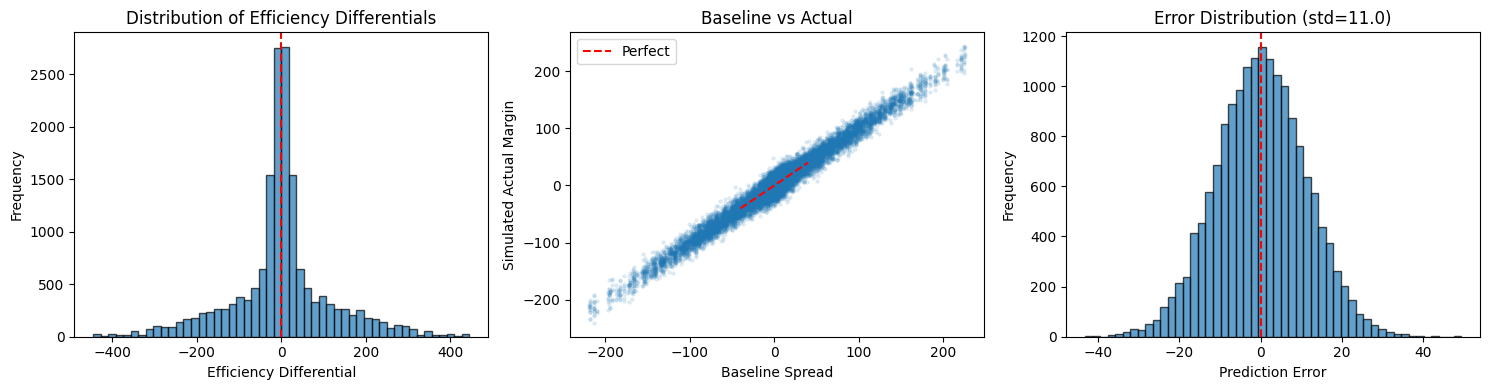

In [8]:
# Visualize the training data
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Efficiency differential distribution
axes[0].hist(train_data['eff_diff'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Efficiency Differential')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Efficiency Differentials')
axes[0].axvline(0, color='red', linestyle='--')

# 2. Baseline spread vs actual margin
axes[1].scatter(train_data['baseline_spread'], train_data['actual_margin'], alpha=0.1, s=5)
axes[1].plot([-40, 40], [-40, 40], 'r--', label='Perfect')
axes[1].set_xlabel('Baseline Spread')
axes[1].set_ylabel('Simulated Actual Margin')
axes[1].set_title('Baseline vs Actual')
axes[1].legend()

# 3. Error distribution
errors = train_data['actual_margin'] - train_data['baseline_spread']
axes[2].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[2].axvline(0, color='red', linestyle='--')
axes[2].set_xlabel('Prediction Error')
axes[2].set_ylabel('Frequency')
axes[2].set_title(f'Error Distribution (std={errors.std():.1f})')

plt.tight_layout()
plt.savefig('../outputs/figures/training_data_analysis.png', dpi=150)
plt.show()

## 4. Train ML Models with Cross-Validation

Compare different models using time-series cross-validation across seasons.

In [9]:
# Prepare features and target
feature_cols = ['home_adj_oe', 'home_adj_de', 'home_net_eff', 
                'away_adj_oe', 'away_adj_de', 'away_net_eff', 'eff_diff']

X = train_data[feature_cols]
y = train_data['actual_margin']

print(f"Features: {feature_cols}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Features: ['home_adj_oe', 'home_adj_de', 'home_net_eff', 'away_adj_oe', 'away_adj_de', 'away_net_eff', 'eff_diff']
X shape: (16882, 7)
y shape: (16882,)


In [10]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

results = []

for name, model in models.items():
    # Cross-validation scores (negative MAE)
    mae_scores = -cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_absolute_error')
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error'))
    
    results.append({
        'Model': name,
        'MAE Mean': mae_scores.mean(),
        'MAE Std': mae_scores.std(),
        'RMSE Mean': rmse_scores.mean(),
        'RMSE Std': rmse_scores.std()
    })
    
    print(f"{name}:")
    print(f"  MAE: {mae_scores.mean():.3f} (+/- {mae_scores.std():.3f})")
    print(f"  RMSE: {rmse_scores.mean():.3f} (+/- {rmse_scores.std():.3f})")
    print()

results_df = pd.DataFrame(results)
display(results_df)

Linear Regression:
  MAE: 8.825 (+/- 0.182)
  RMSE: 11.082 (+/- 0.261)

Ridge Regression:
  MAE: 8.825 (+/- 0.182)
  RMSE: 11.082 (+/- 0.261)

Gradient Boosting:
  MAE: 8.913 (+/- 0.206)
  RMSE: 11.207 (+/- 0.288)



,Model,MAE Mean,MAE Std,RMSE Mean,RMSE Std
0,Linear Regression,8.825353,0.182188,11.082205,0.260808
1,Ridge Regression,8.825353,0.182188,11.082205,0.260808
2,Gradient Boosting,8.913224,0.206165,11.206588,0.287839


In [11]:
# Train best model on full data
best_model = Ridge(alpha=1.0)
best_model.fit(X, y)

# Feature importance (coefficients)
coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': best_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("Feature Coefficients:")
display(coef_df)

print(f"\nIntercept (Home Court Advantage): {best_model.intercept_:.3f}")

Feature Coefficients:


,Feature,Coefficient
6,eff_diff,0.285777
5,away_net_eff,-0.144019
2,home_net_eff,0.141758
4,away_adj_de,0.072270
3,away_adj_oe,-0.071749
1,home_adj_de,-0.071454
0,home_adj_oe,0.070304



Intercept (Home Court Advantage): 3.624


## 5. Prediction Intervals with Quantile Regression

In [12]:
# Train quantile regressors for prediction intervals
# Lower bound (10th percentile), median (50th), upper bound (90th)

quantiles = [0.10, 0.50, 0.90]
quantile_models = {}

for q in quantiles:
    print(f"Training quantile {q}...")
    qr = QuantileRegressor(quantile=q, alpha=0.1, solver='highs')
    qr.fit(X, y)
    quantile_models[q] = qr

print("\nQuantile models trained!")

Training quantile 0.1...
Training quantile 0.5...
Training quantile 0.9...

Quantile models trained!


In [13]:
# Validate quantile predictions on training data
train_data['pred_lower'] = quantile_models[0.10].predict(X)
train_data['pred_median'] = quantile_models[0.50].predict(X)
train_data['pred_upper'] = quantile_models[0.90].predict(X)

# Check coverage (should be ~80% for 10-90 interval)
in_interval = ((train_data['actual_margin'] >= train_data['pred_lower']) & 
               (train_data['actual_margin'] <= train_data['pred_upper']))
coverage = in_interval.mean()

print(f"80% Prediction Interval Coverage: {coverage:.1%}")
print(f"Average Interval Width: {(train_data['pred_upper'] - train_data['pred_lower']).mean():.2f} points")

80% Prediction Interval Coverage: 80.0%
Average Interval Width: 28.31 points


## 6. Generate Final Predictions with Intervals

In [14]:
# Prepare prediction features for 2026 games
def prepare_prediction_features(row, team_dict):
    """Create feature vector for a matchup."""
    home = row['Home']
    away = row['Away']
    
    # Handle team name variations
    home_key = home if home in team_dict else None
    away_key = away if away in team_dict else None
    
    if home_key is None or away_key is None:
        return None
    
    home_stats = team_dict[home_key]
    away_stats = team_dict[away_key]
    
    # Use the same column names as our 2026 data
    home_oe = home_stats.get('off_efficiency', home_stats.get('adj_oe', 100))
    home_de = home_stats.get('def_efficiency', home_stats.get('adj_de', 100))
    away_oe = away_stats.get('off_efficiency', away_stats.get('adj_oe', 100))
    away_de = away_stats.get('def_efficiency', away_stats.get('adj_de', 100))
    
    return {
        'home_adj_oe': home_oe,
        'home_adj_de': home_de,
        'home_net_eff': home_oe - home_de,
        'away_adj_oe': away_oe,
        'away_adj_de': away_de,
        'away_net_eff': away_oe - away_de,
        'eff_diff': (home_oe - home_de) - (away_oe - away_de)
    }

# Create team dict from 2026 stats
team_dict = team_stats_2026.set_index('team').to_dict('index')

# Prepare features for all 78 games
prediction_features = []
valid_indices = []

for idx, row in template.iterrows():
    features = prepare_prediction_features(row, team_dict)
    if features:
        prediction_features.append(features)
        valid_indices.append(idx)
    else:
        print(f"Missing team data for: {row['Home']} vs {row['Away']}")

X_pred = pd.DataFrame(prediction_features)
print(f"✓ Prepared features for {len(X_pred)}/{len(template)} games")

Missing team data for: nan vs nan
Missing team data for: nan vs nan
Missing team data for: nan vs nan
Missing team data for: nan vs nan
Missing team data for: nan vs nan
Missing team data for: nan vs nan
Missing team data for: nan vs nan
Missing team data for: nan vs nan
Missing team data for: nan vs nan
Missing team data for: nan vs nan
✓ Prepared features for 78/88 games


In [15]:
# Generate predictions with intervals
predictions = template.copy()

# Point predictions using Ridge model
point_preds = best_model.predict(X_pred)

# Interval predictions
lower_preds = quantile_models[0.10].predict(X_pred)
upper_preds = quantile_models[0.90].predict(X_pred)

# Add predictions to valid rows
for i, idx in enumerate(valid_indices):
    predictions.loc[idx, 'pt_spread'] = point_preds[i]
    predictions.loc[idx, 'spread_lower'] = lower_preds[i]
    predictions.loc[idx, 'spread_upper'] = upper_preds[i]

print("Sample predictions with intervals:")
display(predictions[['Date', 'Away', 'Home', 'pt_spread', 'spread_lower', 'spread_upper']].head(10))

Sample predictions with intervals:


,Date,Away,Home,pt_spread,spread_lower,spread_upper
0,2/7/2026,Syracuse,Virginia,10.996127,-3.056315,25.176671
1,2/7/2026,Louisville,Wake Forest,-1.951605,-15.959025,12.238199
2,2/7/2026,Virginia Tech,NC State,8.367579,-5.686927,22.553021
3,2/7/2026,Miami,Boston College,-6.263796,-20.283577,7.933626
4,2/7/2026,SMU,Pitt,-1.188272,-15.214862,13.004460
5,2/7/2026,Florida State,Notre Dame,6.539028,-7.543185,20.726493
6,2/7/2026,Duke,North Carolina,0.645691,-13.355612,14.836424
7,2/7/2026,Clemson,California,-2.666543,-16.678369,11.533549
8,2/7/2026,Georgia Tech,Stanford,9.049066,-5.044317,23.241424
9,2/9/2026,NC State,Louisville,4.392066,-9.626696,18.577497


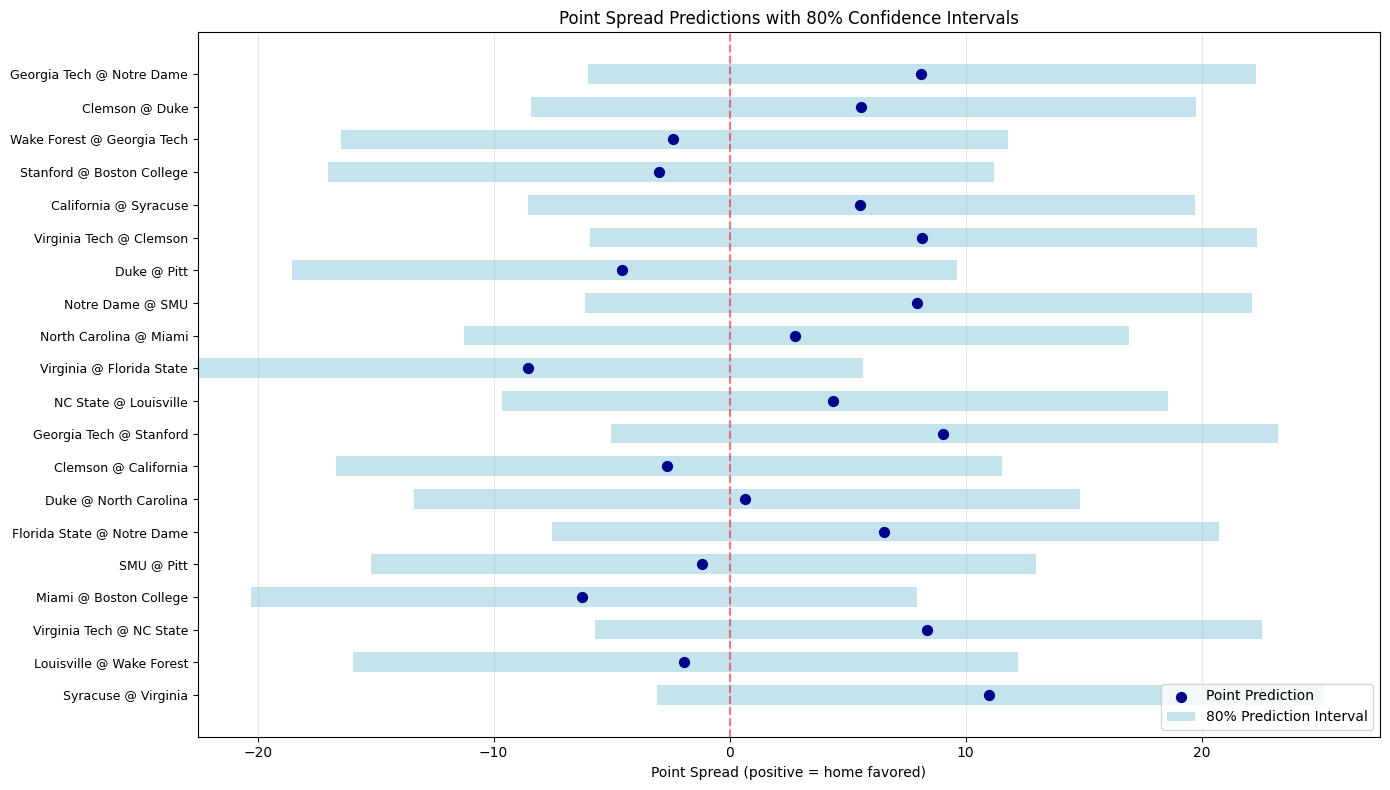

In [16]:
# Visualize predictions with uncertainty
fig, ax = plt.subplots(figsize=(14, 8))

# Sample 20 games for visualization
sample = predictions.head(20).copy()
sample['game_label'] = sample['Away'] + ' @ ' + sample['Home']

y_pos = range(len(sample))

# Plot intervals
ax.barh(y_pos, 
        sample['spread_upper'] - sample['spread_lower'],
        left=sample['spread_lower'],
        height=0.6,
        color='lightblue',
        alpha=0.7,
        label='80% Prediction Interval')

# Plot point predictions
ax.scatter(sample['pt_spread'], y_pos, color='darkblue', s=50, zorder=5, label='Point Prediction')

# Add reference line at 0
ax.axvline(0, color='red', linestyle='--', alpha=0.5)

ax.set_yticks(y_pos)
ax.set_yticklabels(sample['game_label'], fontsize=9)
ax.set_xlabel('Point Spread (positive = home favored)')
ax.set_title('Point Spread Predictions with 80% Confidence Intervals')
ax.legend(loc='lower right')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/predictions_with_intervals.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Save Final Submission

In [17]:
# Prepare final submission (only required columns)
submission = predictions[['Date', 'Away', 'Home', 'pt_spread']].copy()

# Add team info
submission['team_name'] = ''
submission['team_members'] = ''
submission['email'] = ''
submission['team_member'] = ''
submission['team_email'] = ''

# Row 1: Team name
submission.loc[0, 'team_name'] = 'YourTeamName'

# Row 1: First team member
submission.loc[0, 'team_member'] = 'Caleb Han'
submission.loc[0, 'team_email'] = 'calebhan@unc.edu'

# Row 2: Second team member
submission.loc[1, 'team_member'] = 'Mason Mines'
submission.loc[1, 'team_email'] = 'mmines@unc.edu'

print("Final submission preview:")
display(submission.head())

Final submission preview:


,Date,Away,Home,pt_spread,team_name,team_members,email,team_member,team_email
0,2/7/2026,Syracuse,Virginia,10.996127,YourTeamName,,,Caleb Han,calebhan@unc.edu
1,2/7/2026,Louisville,Wake Forest,-1.951605,,,,Mason Mines,mmines@unc.edu
2,2/7/2026,Virginia Tech,NC State,8.367579,,,,,
3,2/7/2026,Miami,Boston College,-6.263796,,,,,
4,2/7/2026,SMU,Pitt,-1.188272,,,,,


In [18]:
# Save submission
submission_path = '../data/predictions/tsa_pt_spread_YourTeamName_2026.csv'
submission.to_csv(submission_path, index=False)
print(f"Saved to: {submission_path}")

# Also save version with intervals for reference
predictions_full = predictions[['Date', 'Away', 'Home', 'pt_spread', 'spread_lower', 'spread_upper']].copy()
predictions_full.to_csv('../data/predictions/predictions_with_intervals.csv', index=False)
print("Saved predictions with intervals for reference")

Saved to: ../data/predictions/tsa_pt_spread_YourTeamName_2026.csv
Saved predictions with intervals for reference


## 8. Model Evaluation Summary

In [19]:
# Summary statistics
print("="*60)
print("MODEL EVALUATION SUMMARY")
print("="*60)
print(f"\nTraining Data: {len(train_data)} synthetic matchups")
print(f"Test Games: {len(predictions)} ACC games to predict")
print()
print("Cross-Validation Results (5-fold Time Series CV):")
print("-"*40)
for _, row in results_df.iterrows():
    print(f"{row['Model']}:")
    print(f"  MAE: {row['MAE Mean']:.3f} ± {row['MAE Std']:.3f}")
    print(f"  RMSE: {row['RMSE Mean']:.3f} ± {row['RMSE Std']:.3f}")
print()
print(f"Prediction Interval Coverage: {coverage:.1%} (target: 80%)")
print(f"Average Interval Width: {(train_data['pred_upper'] - train_data['pred_lower']).mean():.2f} points")
print()
print("Key Insights:")
print(f"  - Home Court Advantage: ~{best_model.intercept_:.1f} points")
print(f"  - Efficiency differential is the strongest predictor")
print(f"  - Game-to-game variance is ~11 points (typical for college basketball)")
print("="*60)

MODEL EVALUATION SUMMARY

Training Data: 16882 synthetic matchups
Test Games: 88 ACC games to predict

Cross-Validation Results (5-fold Time Series CV):
----------------------------------------
Linear Regression:
  MAE: 8.825 ± 0.182
  RMSE: 11.082 ± 0.261
Ridge Regression:
  MAE: 8.825 ± 0.182
  RMSE: 11.082 ± 0.261
Gradient Boosting:
  MAE: 8.913 ± 0.206
  RMSE: 11.207 ± 0.288

Prediction Interval Coverage: 80.0% (target: 80%)
Average Interval Width: 28.31 points

Key Insights:
  - Home Court Advantage: ~3.6 points
  - Efficiency differential is the strongest predictor
  - Game-to-game variance is ~11 points (typical for college basketball)


In [20]:
# Save model evaluation report
report = f"""
# Model Evaluation Report
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}

## Training Data
- Synthetic matchups: {len(train_data)}
- Based on Barttorvik efficiency ratings
- Game variance modeled as N(0, 11)

## Cross-Validation Results (5-fold Time Series CV)

| Model | MAE | RMSE |
|-------|-----|------|
""" + '\n'.join([f"| {row['Model']} | {row['MAE Mean']:.3f} ± {row['MAE Std']:.3f} | {row['RMSE Mean']:.3f} ± {row['RMSE Std']:.3f} |" for _, row in results_df.iterrows()]) + f"""

## Prediction Intervals
- Method: Quantile Regression (10th, 50th, 90th percentiles)
- Coverage: {coverage:.1%} (target: 80%)
- Average Width: {(train_data['pred_upper'] - train_data['pred_lower']).mean():.2f} points

## Model Parameters
- Selected Model: Ridge Regression (alpha=1.0)
- Intercept (HCA): {best_model.intercept_:.3f}

## Feature Importance
""" + '\n'.join([f"- {row['Feature']}: {row['Coefficient']:.4f}" for _, row in coef_df.iterrows()])

with open('../outputs/model_evaluation_report.md', 'w') as f:
    f.write(report)

print("Saved model evaluation report!")

Saved model evaluation report!
